In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from statistics import median, mean
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load Recast Data

In [2]:
# Load models (axial and vector)
inputFiles = ['../CMS-EXO-20-004/scanResults_axial_reduced.pcl',
              '../CMS-EXO-20-004/scanResults_vector_reduced.pcl']
dfs = [pd.read_pickle(i) for i in inputFiles]
recastData = pd.concat(dfs, ignore_index=True)

### Get model points

In [3]:
models = []
mCols = ['Coupling', 'Mode', '$m_{med}$', '$m_{DM}$']
for row in recastData[mCols].values:
    m = dict(zip(mCols, row.tolist()))
    if m not in models:
        models.append(m)

print('%i models loaded.' %len(models))

295 models loaded.


### Get model parameters

In [4]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in ['$m_{med}$','$m_{DM}$']])
print(textstr)

{'Coupling': ['Axial', 'Vector'], 'Mode': 'DM+QCDjets', '$m_{med}$': [450.0, 1250.0, 100.0, 2500.0, 1000.0, 2250.0, 300.0, 750.0, 400.0, 2000.0, 500.0, 1750.0, 3000.0, 250.0, 1500.0, 2750.0], '$m_{DM}$': [1.0, 900.0, 650.0, 400.0, 800.0, 300.0, 1200.0, 60.0, 700.0, 450.0, 200.0, 1100.0, 600.0, 120.0, 100.0, 1000.0, 750.0, 500.0, 1400.0, 250.0]}
Coupling = ['Axial', 'Vector']
Mode = DM+QCDjets


### Obtain Efficiencies

In [5]:
label = [c for c in recastData if (c.startswith("bin_") and not 'Error' in c)]

for l in label:
    ns = recastData[l]
    nsErr = recastData[f'{l}_ErrorPlus']
    lumi = recastData['Luminosity (1/fb)']
    xsec = recastData['Total xsec (pb)']
    recastData[f'{l}_Efficiency'] = ns/(1e3*xsec*lumi)
    recastData[f'{l}_Efficiency_Error'] = nsErr*(recastData[f'{l}_Efficiency'])/ns
    recastData[f'{l}_Efficiency_Error'] = recastData[f'{l}_Efficiency_Error'].replace(np.nan, 0)
    

In [6]:
# Select year
recastData = recastData[recastData['Data-takingperiod'] == 2017]

In [7]:
dataAx = recastData[recastData['Coupling'] == 'Axial']
dataVec = recastData[recastData['Coupling'] == 'Vector']

In [8]:
# Setting the index with mass pairs
effAx = pd.DataFrame([dataAx.set_index(['$m_{med}$', '$m_{DM}$'])[c] for c in recastData if 'Efficiency' in c])
effVec = pd.DataFrame([dataVec.set_index(['$m_{med}$', '$m_{DM}$'])[c] for c in recastData if 'Efficiency' in c])

In [42]:
# Reduced chi squared statistics
maxDiff = []
chis = []
for med, dm in effVec:
    rd = np.abs(effAx[med,dm].iloc[::2] - effVec[med,dm].iloc[::2])/effAx[med,dm].iloc[::2]
    rd = rd.replace(np.inf, 0)
    rd = rd.max()
    d = (effAx[med,dm].iloc[::2] - effVec[med,dm].iloc[::2])**2
    d = d.replace(np.inf, 0)
    errd = effAx[med,dm].iloc[1::2]**2 + effVec[med,dm].iloc[1::2]**2
    errd = errd.replace(np.inf, 0)
    chi = []
    for i in range(len(d)):
        if d[i] == 0:
            chi.append(0)
        else:
            chi.append(d[i]/errd[i])
#     chi = [d[i]/errd[i] for i in range(len(d))]
#     chi = [0 if np.isnan(i) else i for i in chi]
    chis.append(sum(chi)/len(d))
    maxDiff.append(rd)
    

In [43]:
len(chis)

147

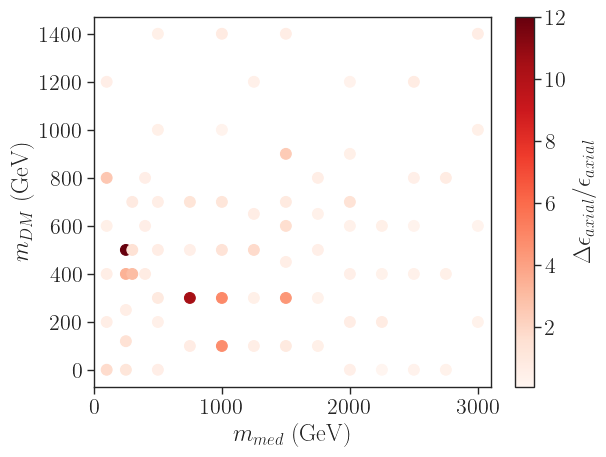

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Filter dataVec to match the length of maxDiff
filtered_dataVec = dataVec.iloc[::2]

# Filter maxDiff to match the length of filtered_dataVec
filtered_maxDiff = maxDiff[:len(filtered_dataVec)]

# Normalize maxDiff values between 0 and 1
norm = mcolors.Normalize(vmin=np.min(filtered_maxDiff), vmax=np.max(filtered_maxDiff))
cmap = plt.cm.get_cmap('Reds')

# Plot results
plt.scatter(x=filtered_dataVec['$m_{med}$'], y=filtered_dataVec['$m_{DM}$'], c=filtered_maxDiff,
            cmap=cmap, s=60, norm=norm)

cbar = plt.colorbar(label=r'$\Delta \epsilon_{axial}/\epsilon_{axial}$')
plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0, 3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.show()

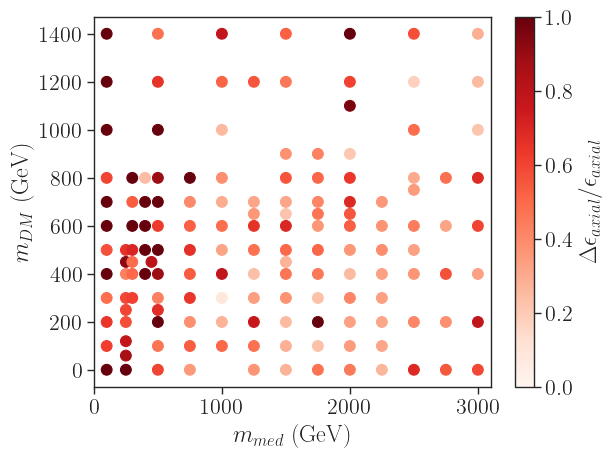

In [46]:
# Plot results
plt.scatter(x=dataVec['$m_{med}$'], y=dataVec['$m_{DM}$'], vmin=0., vmax=1., c=maxDiff, 
            cmap=plt.cm.get_cmap('Reds'), s=60)

cbar=plt.colorbar(label=r'$\Delta \epsilon_{axial}/\epsilon_{axial}$')
plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
# plt.ylim(-10,1500)
plt.show()

In [47]:
pts = np.array([x for x in product(np.linspace(0.,3000.,100),np.linspace(0.,1500.,100))])
relDiffPts = griddata(list(zip(dataVec['$m_{med}$'],dataVec['$m_{DM}$'])),
                  maxDiff,pts)
pts = pts[~np.isnan(relDiffPts)]
relDiffPts = relDiffPts[~np.isnan(relDiffPts)]

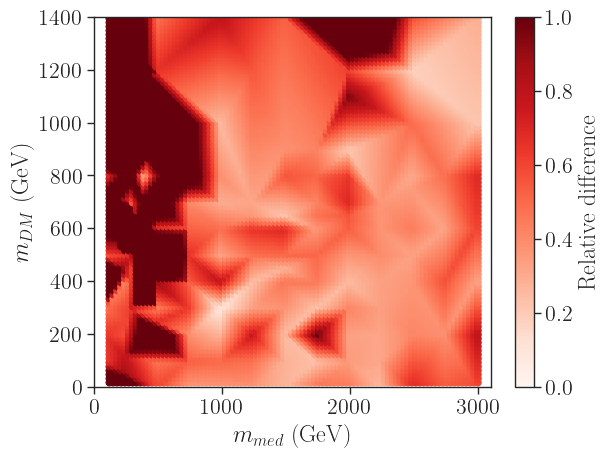

In [48]:
plt.scatter(x=pts[:,0], y=pts[:,1], vmin=0., vmax =1., 
            c=relDiffPts, cmap=plt.cm.get_cmap('Reds'))
cbar = plt.colorbar(label='Relative difference')


plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.ylim(0,1400)
plt.show()

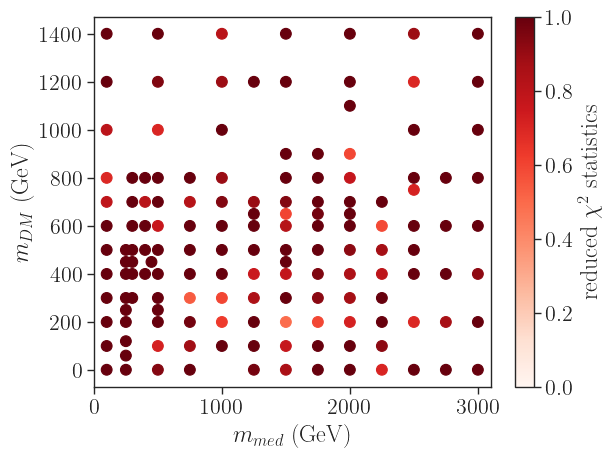

In [49]:
# Plot results
plt.scatter(x=dataVec['$m_{med}$'], y=dataVec['$m_{DM}$'], vmin=0., vmax=1., c=chis, 
            cmap=plt.cm.get_cmap('Reds'), s=60)

cbar=plt.colorbar(label=r'reduced $\chi^{2}$ statistics')
plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
# plt.ylim(-10,1500)
plt.show()

In [50]:
chisPts = griddata(list(zip(dataVec['$m_{med}$'],dataVec['$m_{DM}$'])),
                  chis,pts)
ptsChi = pts[~np.isnan(chisPts)]
chisPts = chisPts[~np.isnan(chisPts)]

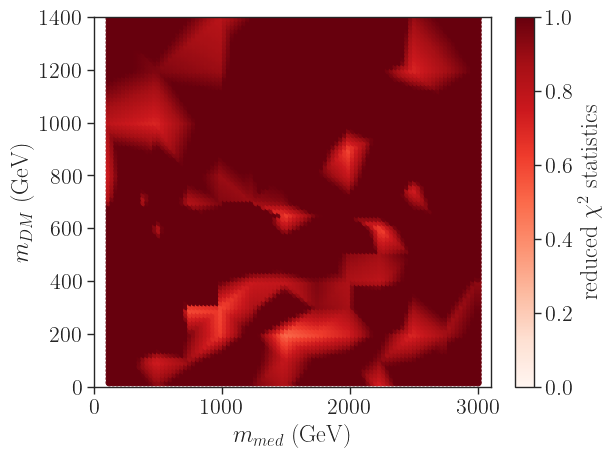

In [51]:
plt.scatter(x=ptsChi[:,0], y=ptsChi[:,1], vmin=0., vmax =1., 
            c=chisPts, cmap=plt.cm.get_cmap('Reds'))
cbar = plt.colorbar(label=r'reduced $\chi^{2}$ statistics')


plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.ylim(0,1400)
plt.show()

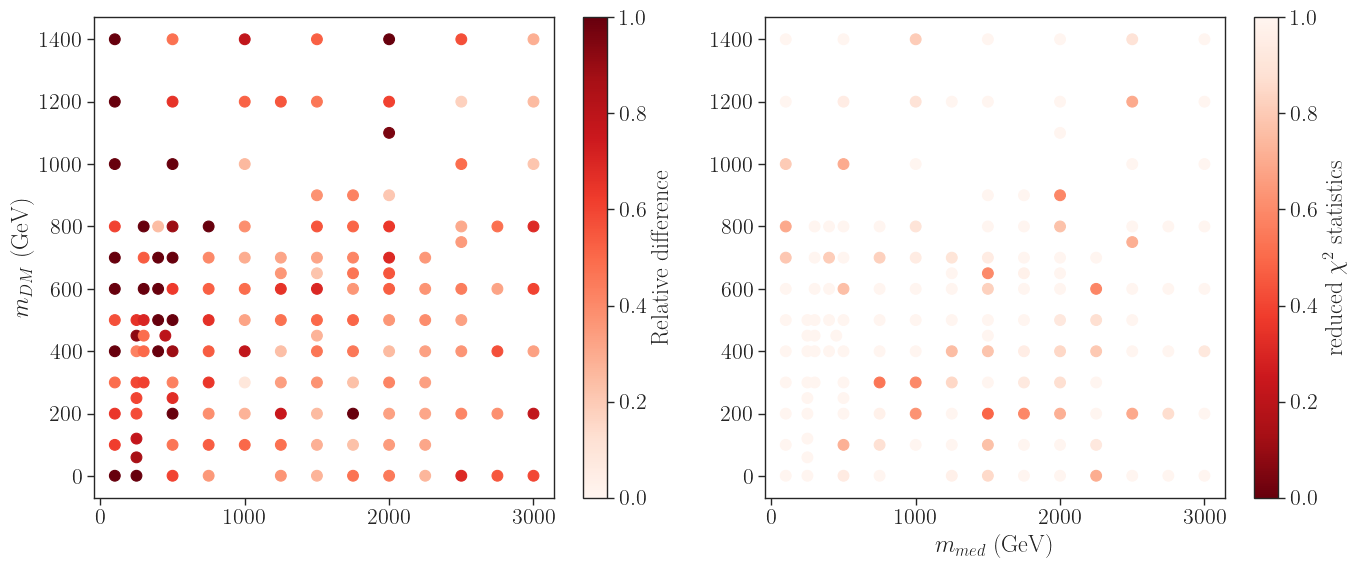

In [58]:
fig,ax = plt.subplots(figsize=(14,6),ncols=2,nrows=1)

p1 = ax[0].scatter(x=dataVec['$m_{med}$'], y=dataVec['$m_{DM}$'], vmin=0., vmax=1., c=maxDiff, 
            cmap=plt.cm.get_cmap('Reds'), s=60)

p2 = ax[1].scatter(x=dataVec['$m_{med}$'], y=dataVec['$m_{DM}$'], vmin=0., vmax=1., c=chis, 
             cmap=plt.cm.get_cmap('Reds_r'), s=60)

ax[0].set_ylabel(r'$m_{DM}$ (GeV)')
ax[1].set_xlabel(r'$m_{med}$ (GeV)')

cbar1 = plt.colorbar(p1, label='Relative difference', ax=ax[0])
cbar2 = plt.colorbar(p2, label=r'reduced $\chi^{2}$ statistics', ax=ax[1])
plt.tight_layout()
plt.show()

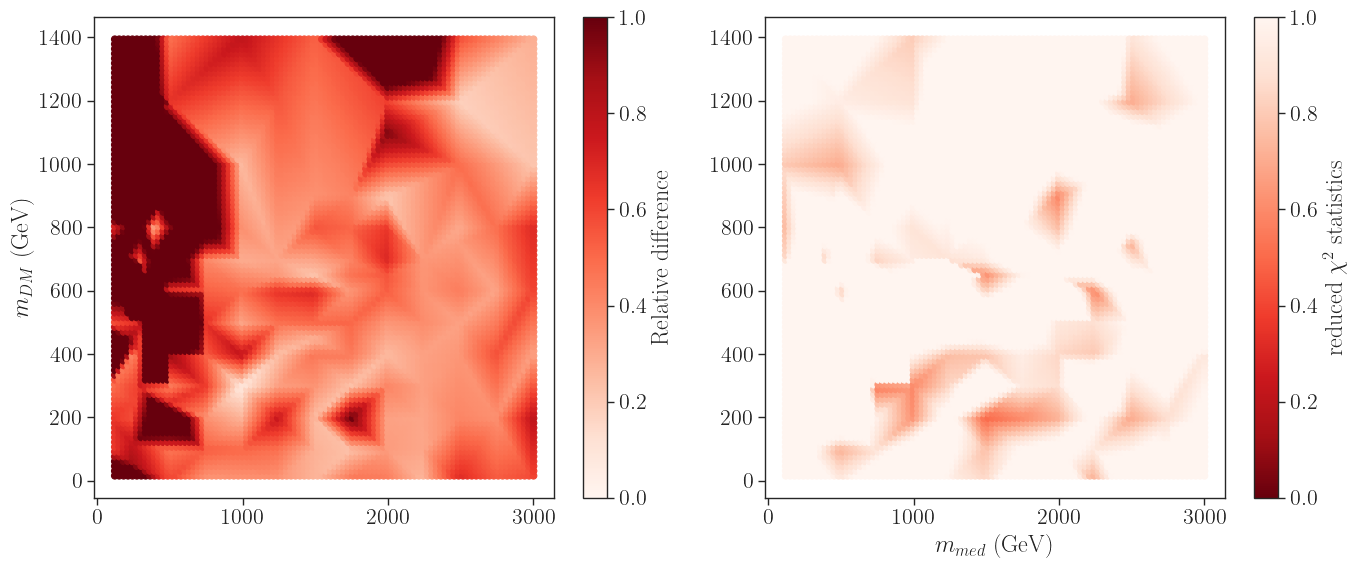

In [57]:
fig,ax = plt.subplots(figsize=(14,6),ncols=2,nrows=1)

p1 = ax[0].scatter(x=pts[:,0], y=pts[:,1], vmin=0., vmax =1., c=relDiffPts, cmap=plt.cm.get_cmap('Reds'))
# ax[0].axline((1, 1), slope=1/2, linestyle='--', color='gray')

p2 = ax[1].scatter(x=ptsChi[:,0], y=ptsChi[:,1], vmin=0., vmax =1., c=chisPts, cmap=plt.cm.get_cmap('Reds_r'))

ax[0].set_ylabel(r'$m_{DM}$ (GeV)')
ax[1].set_xlabel(r'$m_{med}$ (GeV)')

cbar1 = plt.colorbar(p1, label='Relative difference', ax=ax[0])
cbar2 = plt.colorbar(p2, label=r'reduced $\chi^{2}$ statistics', ax=ax[1])
plt.tight_layout()
plt.show()

In [19]:
from scipy.stats import ks_2samp

In [20]:
pval = []
for med, dm in effVec:
    p = ks_2samp(effAx[med, dm], effVec[med, dm]).pvalue
    pval.append(p)

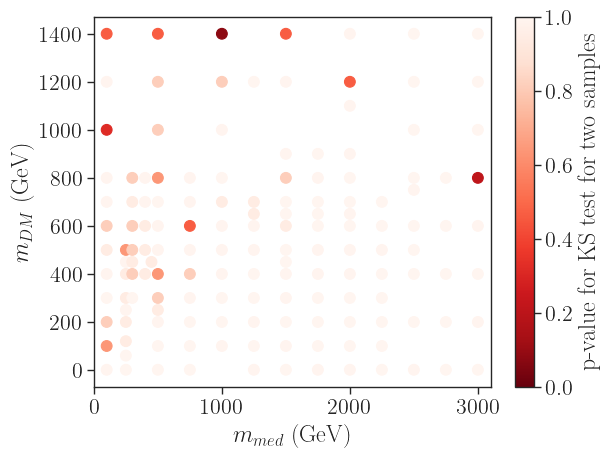

In [25]:
# Plot results
plt.scatter(x=dataVec['$m_{med}$'], y=dataVec['$m_{DM}$'], vmin=0., vmax=1., c=pval, 
            cmap=plt.cm.get_cmap('Reds_r'), s=60)

cbar=plt.colorbar(label='p-value for KS test for two samples')
plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
# plt.ylim(-10,1500)
plt.show()

In [22]:
diff2 = []
for med, dm in effVec:
    d = np.abs(effAx[med, dm] - effVec[med, dm])/effAx[med, dm]
    d = d.replace(np.inf, 0)
    d2 = np.sort(d)
    d = d.max()
    d2 = d2[:-2].max()
    diff2.append((d-d2)/2)

In [23]:
pts = np.array([x for x in product(np.linspace(0.,3000.,100),np.linspace(0.,1500.,100))])
relDiffPts = griddata(list(zip(dataVec['$m_{med}$'],dataVec['$m_{DM}$'])),
                  diff2,pts)
pts = pts[~np.isnan(relDiffPts)]
relDiffPts = relDiffPts[~np.isnan(relDiffPts)]

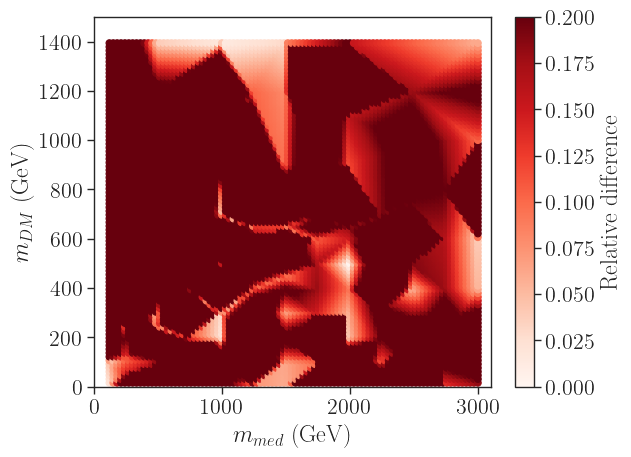

In [24]:
plt.scatter(x=pts[:,0], y=pts[:,1], vmin=0., vmax =.2, 
            c=relDiffPts, cmap=plt.cm.get_cmap('Reds'))
cbar = plt.colorbar(label='Relative difference')


plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.ylim(0,1500)
plt.show()